In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), 'dbn-utls'))
import pickle
import copy
from tqdm import tqdm

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')

from dotenv import load_dotenv
load_dotenv(os.path.join(os.getcwd(), 'config.env'))

PATH_DATA  = os.getenv('PATH_DATA')
PATH_MODEL = os.getenv('PATH_MODEL')

test_dataset = pickle.load(open(os.path.join(PATH_DATA, 'MNIST', 'test_dataset.pkl'), 'rb'))
Xtest = test_dataset['data']
Ytest = test_dataset['labels']

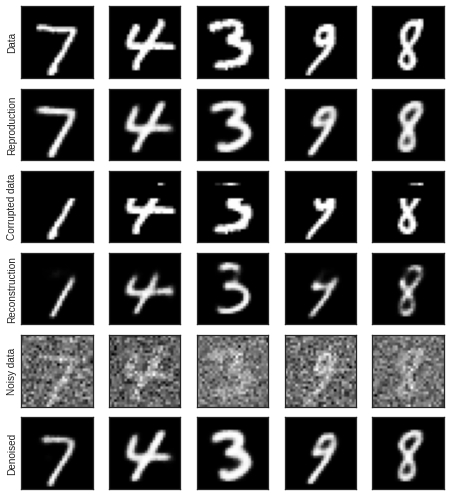

In [23]:

algo = 'g'
if algo == 'g':
    aname = 'greedy'
elif algo == 'i':
    aname = 'iterative'
elif algo == 'fs':
    aname = 'fullstack'
#end
init_scheme = 'glorot'

test_errors = pickle.load(open(os.path.join(PATH_MODEL, 'server', f'{algo}DBN', 
                                            'MNIST', f'test_errors_{init_scheme}.pkl'), 'rb'))
errors_repr = test_errors['repr']
mean_repr = errors_repr.mean()
best_model_idx = errors_repr.argmin()
model = torch.load(open(os.path.join(PATH_MODEL, 'server', f'{algo}DBN', 'MNIST', 
                             f'dbn_{aname}_normal_MNIST_run{best_model_idx}.pkl'), 'rb'),
                       map_location = torch.device('cpu'))

erepr, drepr, irepr = model.test(Xtest, Ytest, mode = 'reproduction', return_only_error = False)
ereco, dreco, ireco = model.test(Xtest, Ytest, mode = 'reconstruction', return_only_error = False)
edeno, ddeno, ideno = model.test(Xtest, Ytest, mode = 'denoise', return_only_error = False)

cols = 5
fig, ax = plt.subplots(6, cols, figsize = (6.5,7))
# indices = np.random.randint(0, Xtest.shape[0], cols)
indices = [ 0, 55,  5, 10, 53]

for j, idx in enumerate(indices):
    ax[0,j].imshow(Xtest[idx,0,:].reshape(28, 28), cmap = 'gray')
    ax[0,j].set_xticks([]); ax[0,j].set_yticks([])
#end
ax[0,0].set_ylabel('Data')
for j, idx in enumerate(indices):
    ax[1,j].imshow(drepr[idx,0,:].reshape(28, 28), cmap = 'gray')
    ax[1,j].set_xticks([]); ax[1,j].set_yticks([])
#end
ax[1,0].set_ylabel('Reproduction')
for j, idx in enumerate(indices):
    ax[2,j].imshow(ireco[idx,0,:].reshape(28, 28), cmap = 'gray')
    ax[2,j].set_xticks([]); ax[2,j].set_yticks([])
#end
ax[2,0].set_ylabel('Corrupted data')
for j, idx in enumerate(indices):
    ax[3,j].imshow(dreco[idx,0,:].reshape(28, 28), cmap = 'gray')
    ax[3,j].set_xticks([]); ax[3,j].set_yticks([])
#end
ax[3,0].set_ylabel('Reconstruction')
for j, idx in enumerate(indices):
    ax[4,j].imshow(ideno[idx,0,:].reshape(28, 28), cmap = 'gray')
    ax[4,j].set_xticks([]); ax[4,j].set_yticks([])
#end
ax[4,0].set_ylabel('Noisy data')
for j, idx in enumerate(indices):
    ax[5,j].imshow(ddeno[idx,0,:].reshape(28, 28), cmap = 'gray')
    ax[5,j].set_xticks([]); ax[5,j].set_yticks([])
#end
ax[5,0].set_ylabel('Denoised')
fig.tight_layout()
fig.savefig(f'./plots/datavis_{algo}DBN_{init_scheme}.pdf', format = 'pdf', dpi = 300, bbox_inches = 'tight')
plt.show(fig)

In [8]:
errors_greedy = { 'repr' : np.zeros(10), 'reco' : np.zeros(10), 'deno' : np.zeros(10) }
errors_iter   = { 'repr' : np.zeros(10), 'reco' : np.zeros(10), 'deno' : np.zeros(10) }

for i in tqdm(range(10)):
    
    model = torch.load(open(os.path.join(PATH_MODEL, 'server', 'gDBN', 'MNIST', 
                             f'dbn_greedy_normal_MNIST_run{i}.pkl'), 'rb'),
                       map_location = torch.device('cpu'))
    
    errors_greedy['repr'][i] = model.test(Xtest, Ytest, mode = 'reproduction', return_only_error = True)
    errors_greedy['reco'][i] = model.test(Xtest, Ytest, mode = 'reconstruction', return_only_error = True)
    errors_greedy['deno'][i] = model.test(Xtest, Ytest, mode = 'denoise', return_only_error = True)
#end

for i in tqdm(range(10)):
    
    model = torch.load(open(os.path.join(PATH_MODEL, 'server', 'iDBN', 'MNIST', 
                             f'dbn_iterative_normal_MNIST_run{i}.pkl'), 'rb'),
                       map_location = torch.device('cpu'))
    
    errors_iter['repr'][i] = model.test(Xtest, Ytest, mode = 'reproduction', return_only_error = True)
    errors_iter['reco'][i] = model.test(Xtest, Ytest, mode = 'reconstruction', return_only_error = True)
    errors_iter['deno'][i] = model.test(Xtest, Ytest, mode = 'denoise', return_only_error = True)
#end

100%|███████████████████████████████████████████| 10/10 [01:05<00:00,  6.53s/it]


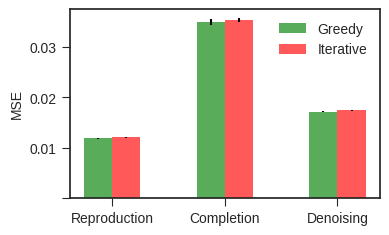

In [9]:

init_scheme = 'glorot'

fig, ax = plt.subplots(figsize = (4, 2.5), dpi = 100)

span = np.array([0, 1, 2])
gerr_means = np.array([errors_greedy['repr'].mean(), 
                       errors_greedy['reco'].mean(),
                       errors_greedy['deno'].mean()])
gerr_stds = np.array([errors_greedy['repr'].std(), 
                       errors_greedy['reco'].std(),
                       errors_greedy['deno'].std()])
ierr_means = np.array([errors_iter['repr'].mean(), 
                       errors_iter['reco'].mean(),
                       errors_iter['deno'].mean()])
ierr_stds = np.array([errors_iter['repr'].std(), 
                       errors_iter['reco'].std(),
                       errors_iter['deno'].std()])
ax.bar(span-0.125, gerr_means, width = 0.25, facecolor = 'g', yerr = gerr_stds, alpha = 0.65, label = 'Greedy')
ax.bar(span+0.125, ierr_means, width = 0.25, facecolor = 'r', yerr = ierr_stds, alpha = 0.65, label = 'Iterative')
ax.set_xticks(span)
ax.set_xticklabels(['Reproduction', 'Completion', 'Denoising'])
ax.set_ylabel('MSE')
ax.set_yticks([0., 0.01, 0.02, 0.03])
ax.set_yticklabels(['', '0.01', '0.02', '0.03'])

ax.legend()
fig.savefig(f'./plots/test_errors_{init_scheme}.pdf', format = 'pdf', dpi = 300, bbox_inches = 'tight')
plt.show(fig)


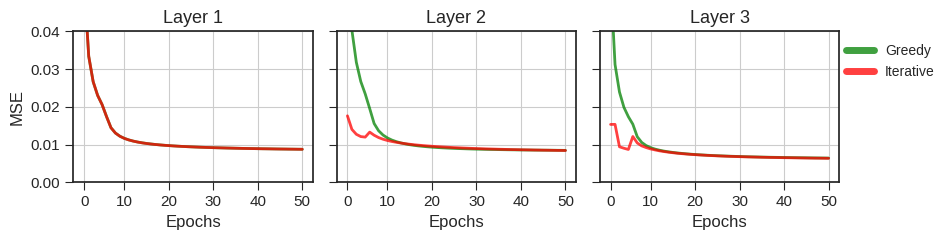

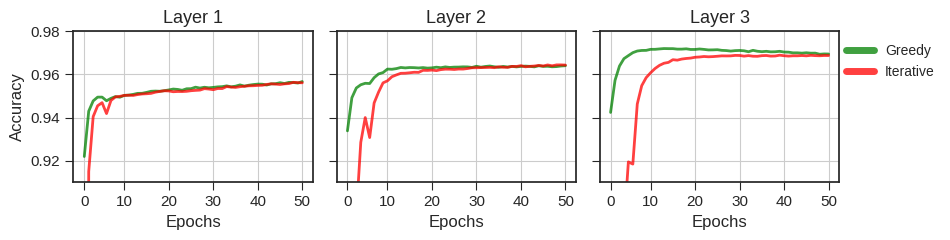

In [11]:
import copy
init_scheme = 'glorot'

loss_metrics_greedy = pickle.load(open(os.path.join(os.getcwd(), PATH_MODEL, 
                                       'server', 'gDBN', 'MNIST', 
                                       f'loss_metrics_{init_scheme}.pkl'), 'rb'))
loss_metrics_iterative = pickle.load(open(os.path.join(os.getcwd(), PATH_MODEL, 
                                          'server', 'iDBN', 'MNIST', 
                                          f'loss_metrics_{init_scheme}.pkl'), 'rb'))
glm = loss_metrics_greedy.mean(axis = 0)
ilm = loss_metrics_iterative.mean(axis = 0)

fig, ax = plt.subplots(1,3, figsize = (9.5,2.5), dpi = 100, sharey = True)
for i in range(3):
    ax[i].plot(glm[:,i], color = 'g', lw = 2, alpha = 0.75, label = 'Greedy')
    ax[i].plot(ilm[:,i], color = 'r', lw = 2, alpha = 0.75, label = 'Iterative')
    ax[i].grid()
    ax[i].set_title(f'Layer {i+1}', fontsize = 13)
    ax[i].set_xlabel('Epochs', fontsize = 12)
    ax[i].set_ylim([0., 0.04])
    ax[i].set_xticks([0, 9, 19, 29, 39, 49])
    ax[i].set_xticklabels([0, 10, 20, 30, 40, 50])
    ax[i].tick_params(axis='both', which='major', labelsize=11)
#end
handles, labels = ax[-1].get_legend_handles_labels()
handles = [copy.copy(ha) for ha in handles ]
[ha.set_linewidth(5) for ha in handles ]
ax[-1].legend(handles = handles, bbox_to_anchor = (1.45, 1))
ax[0].set_ylabel('MSE', fontsize = 12)
fig.tight_layout()
fig.savefig(f'./plots/lossprofiles_{init_scheme}.pdf', format = 'pdf', dpi = 300, bbox_inches = 'tight')
plt.show(fig)

acc_metrics_greedy = pickle.load(open(os.path.join(os.getcwd(), PATH_MODEL, 
                                                   'server', 'gDBN', 'MNIST', 
                                                   f'acc_metrics_{init_scheme}.pkl'), 'rb'))
acc_metrics_iterative = pickle.load(open(os.path.join(os.getcwd(), PATH_MODEL, 
                                                      'server', 'iDBN', 'MNIST', 
                                                      f'acc_metrics_{init_scheme}.pkl'), 'rb'))
gam = np.nanmean(acc_metrics_greedy, axis = 0)
iam = np.nanmean(acc_metrics_iterative, axis = 0)

gams = list()
iams = list()
for i in range(3):
    gams.append(gam[:,i][~np.isnan(gam[:,i])])
    iams.append(iam[:,i][~np.isnan(iam[:,i])])
#end

fig, ax = plt.subplots(1,3, figsize = (9.5,2.5), dpi = 100, sharey = True)
for i in range(3):
    ax[i].plot(gams[i], color = 'g', lw = 2, alpha = 0.75, label = 'Greedy')
    ax[i].plot(iams[i], color = 'r', lw = 2, alpha = 0.75, label = 'Iterative')
    ax[i].set_ylim([0.91, 0.98])
    ax[i].grid()
    ax[i].set_title(f'Layer {i+1}', fontsize = 13)
    ax[i].set_xlabel('Epochs', fontsize = 12)
    ax[i].set_xticks([0, 9, 19, 29, 39, 49])
    ax[i].set_xticklabels([0, 10, 20, 30, 40, 50])
    ax[i].tick_params(axis='both', which='major', labelsize=11)
#end
handles, labels = ax[-1].get_legend_handles_labels()
handles = [copy.copy(ha) for ha in handles ]
[ha.set_linewidth(5) for ha in handles ]
ax[-1].legend(handles = handles, bbox_to_anchor = (1.45, 1))
ax[0].set_ylabel('Accuracy', fontsize = 12)
fig.tight_layout()
fig.savefig(f'./plots/accprofiles_{init_scheme}.pdf', format = 'pdf', dpi = 300, bbox_inches = 'tight')
plt.show(fig)

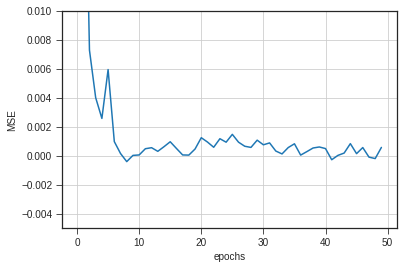

In [4]:
err = (gams[0] - iams[0])
plt.plot(err)
plt.ylim([-0.005, 0.01])
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.grid()
plt.savefig('./plots/error_gi.png')

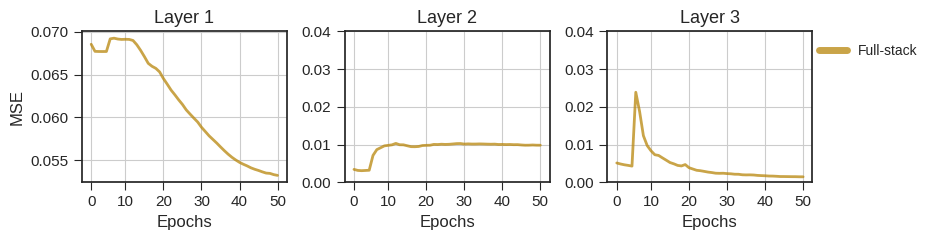

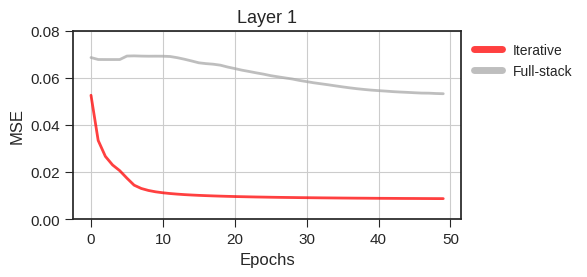

In [13]:
loss_metrics_fullstack = pickle.load(open(os.path.join(os.getcwd(), PATH_MODEL, 
                                          'server', 'fsDBN', 'MNIST', 
                                          'loss_metrics_normal.pkl'), 'rb'))
acc_metrics_fullstack = pickle.load(open(os.path.join(os.getcwd(), PATH_MODEL, 
                                                      'server', 'fsDBN', 'MNIST', 
                                                      'acc_metrics_normal.pkl'), 'rb'))

fslm = loss_metrics_fullstack.mean(axis = 0)
fsam = np.nanmean(acc_metrics_fullstack, axis = 0)

fig, ax = plt.subplots(1,3, figsize = (9.5, 2.5), dpi = 100)
for i in range(3):
    ax[i].plot(fslm[:,i], color = 'darkgoldenrod', alpha = 0.75, lw = 2, label = f'Full-stack')
    ax[i].grid()
    ax[i].set_title(f'Layer {i+1}', fontsize = 13)
    ax[i].set_xlabel('Epochs', fontsize = 12)
    if i > 0:
        ax[i].set_ylim([0., 0.04])
    ax[i].set_xticks([0, 9, 19, 29, 39, 49])
    ax[i].set_xticklabels([0, 10, 20, 30, 40, 50])
    ax[i].tick_params(axis='both', which='major', labelsize=11)
#end
handles, labels = ax[-1].get_legend_handles_labels()
handles = [copy.copy(ha) for ha in handles ]
[ha.set_linewidth(5) for ha in handles ]
ax[-1].legend(handles = handles, bbox_to_anchor = (1.575, 1))
ax[0].set_ylabel('MSE', fontsize = 12)
fig.tight_layout()
fig.savefig('./plots/fs_layersloss.pdf', format = 'pdf', dpi = 300, bbox_inches = 'tight')
plt.show(fig)

fig, ax = plt.subplots(figsize = (5, 2.5), dpi = 100)
ax.plot(ilm[:,0], color = 'r', alpha = 0.75, lw = 2, label = 'Iterative')
ax.plot(fslm[:,0], color = 'darkgray', alpha = 0.75, lw = 2, label = 'Full-stack')
ax.grid()
ax.set_ylim([0., 0.08])
ax.set_xlabel('Epochs', fontsize = 12)
ax.set_ylabel('MSE', fontsize = 12)
ax.set_title('Layer 1', fontsize = 13)
ax.tick_params(axis='both', which='major', labelsize=11)
handles, labels = ax.get_legend_handles_labels()
handles = [copy.copy(ha) for ha in handles ]
[ha.set_linewidth(5) for ha in handles ]
ax.legend(handles = handles, bbox_to_anchor = (1.32, 1))
fig.savefig(f'./plots/lossL1_normal_greedy_vs_fullstack.pdf', format = 'pdf', dpi = 300, bbox_inches = 'tight')
plt.show(fig)


In [2]:
loss_metrics_fullstack = pickle.load(open(os.path.join(os.getcwd(), PATH_MODEL, 
                                          'server', 'fsDBN', 'MNIST', 
                                          'loss_metrics_normal.pkl'), 'rb'))
acc_metrics_fullstack = pickle.load(open(os.path.join(os.getcwd(), PATH_MODEL, 
                                                      'server', 'fsDBN', 'MNIST', 
                                                      'acc_metrics_normal.pkl'), 'rb'))

errors_greedy = { 'repr' : np.zeros(10), 'reco' : np.zeros(10), 'deno' : np.zeros(10) }
errors_iter   = { 'repr' : np.zeros(10), 'reco' : np.zeros(10), 'deno' : np.zeros(10) }
errors_fs     = { 'repr' : np.zeros(10), 'reco' : np.zeros(10), 'deno' : np.zeros(10) }

for i in tqdm(range(10)):
    
    model = torch.load(open(os.path.join(PATH_MODEL, 'server', 'gDBN', 'MNIST', 
                             f'dbn_greedy_normal_MNIST_run{i}.pkl'), 'rb'),
                       map_location = torch.device('cpu'))
    
    errors_greedy['repr'][i] = model.test(Xtest, Ytest, mode = 'reproduction', return_only_error = True)
    errors_greedy['reco'][i] = model.test(Xtest, Ytest, mode = 'reconstruction', return_only_error = True)
    errors_greedy['deno'][i] = model.test(Xtest, Ytest, mode = 'denoise', return_only_error = True)
#end

for i in tqdm(range(10)):
    
    model = torch.load(open(os.path.join(PATH_MODEL, 'server', 'iDBN', 'MNIST', 
                             f'dbn_iterative_normal_MNIST_run{i}.pkl'), 'rb'),
                       map_location = torch.device('cpu'))
    
    errors_iter['repr'][i] = model.test(Xtest, Ytest, mode = 'reproduction', return_only_error = True)
    errors_iter['reco'][i] = model.test(Xtest, Ytest, mode = 'reconstruction', return_only_error = True)
    errors_iter['deno'][i] = model.test(Xtest, Ytest, mode = 'denoise', return_only_error = True)
#end

for i in tqdm(range(10)):
    
    model = torch.load(open(os.path.join(PATH_MODEL, 'server', 'fsDBN', 'MNIST', 
                             f'dbn_fullstack_normal_MNIST_run{i}.pkl'), 'rb'),
                       map_location = torch.device('cpu'))
    
    errors_fs['repr'][i] = model.test(Xtest, Ytest, mode = 'reproduction', return_only_error = True)
    errors_fs['reco'][i] = model.test(Xtest, Ytest, mode = 'reconstruction', return_only_error = True)
    errors_fs['deno'][i] = model.test(Xtest, Ytest, mode = 'denoise', return_only_error = True)
#end

100%|███████████████████████████████████████████| 10/10 [00:28<00:00,  2.89s/it]


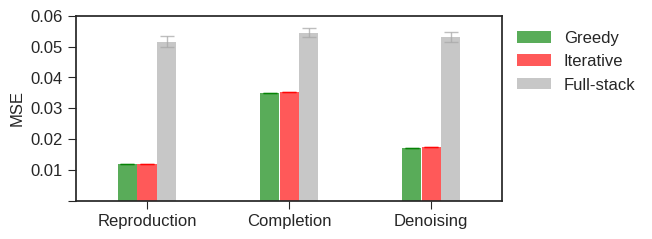

In [7]:
init_scheme = 'normal'

fig, ax = plt.subplots(figsize = (5.5, 2.45), dpi = 100)

span = np.array([0, 1, 2])
gerr_means = np.array([errors_greedy['repr'].mean(), 
                       errors_greedy['reco'].mean(),
                       errors_greedy['deno'].mean()])
gerr_stds = np.array([errors_greedy['repr'].std(), 
                       errors_greedy['reco'].std(),
                       errors_greedy['deno'].std()]) / 10
ierr_means = np.array([errors_iter['repr'].mean(), 
                       errors_iter['reco'].mean(),
                       errors_iter['deno'].mean()])
ierr_stds = np.array([errors_iter['repr'].std(), 
                       errors_iter['reco'].std(),
                       errors_iter['deno'].std()]) / 10
fserr_means = np.array([errors_fs['repr'].mean(), 
                       errors_fs['reco'].mean(),
                       errors_fs['deno'].mean()])
fserr_stds = np.array([errors_fs['repr'].std(), 
                       errors_fs['reco'].std(),
                       errors_fs['deno'].std()]) / 10
ax.bar(span-0.1378, gerr_means, width = 0.135, yerr = gerr_stds,
       error_kw = dict(lw = 1, capsize = 5, capthick = 1, ecolor = 'g', alpha = 0.75),
       facecolor = 'g', alpha = 0.65, label = 'Greedy')
ax.bar(span, ierr_means, width = 0.135, yerr = ierr_stds,
       error_kw = dict(lw = 1, capsize = 5, capthick = 1, ecolor = 'r', alpha = 0.75),
       facecolor = 'r', alpha = 0.65, label = 'Iterative')
ax.bar(span+0.1378, fserr_means, width = 0.135, yerr = fserr_stds,
       error_kw = dict(lw = 1, capsize = 5, capthick = 1, ecolor = 'darkgray', alpha = 0.75),
       facecolor = 'darkgray', alpha = 0.65, label = 'Full-stack')
ax.set_xticks(span)
ax.set_xticklabels(['Reproduction', 'Completion', 'Denoising'], fontsize = 11)
ax.set_ylabel('MSE', fontsize = 12)
ax.set_yticks([0., 0.01, 0.02, 0.03, 0.04, 0.05, 0.06])
ax.set_yticklabels(['', '0.01', '0.02', '0.03', '0.04', '0.05', '0.06'])
ax.set_xlim([-0.5, 2.5])
ax.tick_params(axis='both', which='major', labelsize=12)

ax.legend(bbox_to_anchor = (1.00, 1), fontsize = 12)
fig.savefig(f'./plots/test_errors_{init_scheme}_all.pdf', format = 'pdf', dpi = 300, bbox_inches = 'tight')
plt.show(fig)


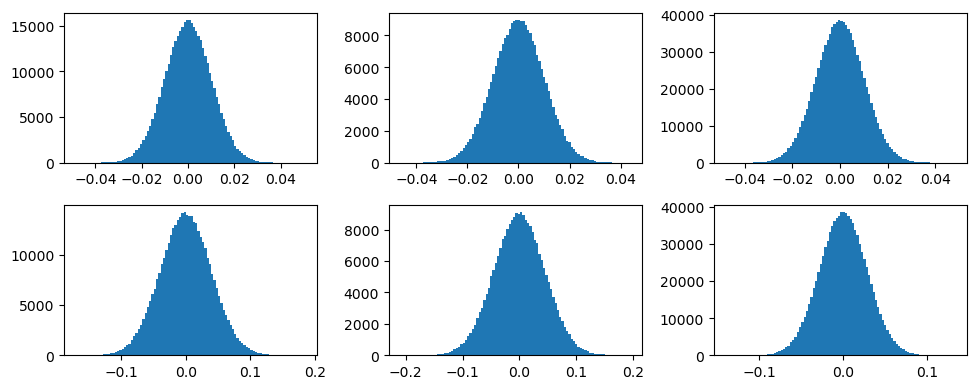

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt

shapes = ( (784, 500), (500, 500), (500, 2000) )
fig, ax = plt.subplots(2,3, figsize = (10,4), dpi = 100)
for j in range(3):
    w = torch.nn.init.normal_(torch.empty(shapes[j][1], shapes[j][0]), mean = 0, std = 1) * 0.01
    w = w.flatten().numpy()
    ax[0,j].hist(w, bins = 100)
#end
for j in range(3):
    w = torch.nn.init.xavier_normal_(torch.empty(shapes[j][1], shapes[j][0]), gain = 1)
    w = w.flatten().numpy()
    ax[1,j].hist(w, bins = 100)
#end
fig.tight_layout()
plt.show()